In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv, concat
from arviz import hdi
sns.set_theme(style='ticks', context='notebook', font_scale=1.2)

## Section 1: Model Diagnostics

In [2]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3', 's4']

### 1.1 Stan diagnostics


In [3]:
## Main loop.
diagnostics = []
for m in models:
    
    for s in sessions:
        
        ## Load Stan summary.
        samples = read_csv(os.path.join('stan_results', s, f'{m}.tsv.gz'), sep='\t', compression='gzip')
        summary = read_csv(os.path.join('stan_results', s, f'{m}_summary.tsv'), sep='\t', index_col=0)
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Apply restrictions.
        ppc = ppc[~np.isinf(ppc.k_u)]

        ## Identify number of divergences.
        divergence = samples.divergent__.sum()

        ## Identify parameters failing to reach convergence.
        rhat = len(summary.query('R_hat >= 1.02'))
        
        ## Identify parameters with low effective sample size.
        n_eff = len(summary.query('N_Eff < 400'))

        ## Identify number of effective parameters.
        p_loo = ppc.pwaic.sum()

        ## Identify number of poorly predicted observations.
        pk = np.sum(ppc.k_u > 0.7)

        ## Convert to dictionary. Append.
        diagnostics.append(dict(
            model = m,
            session = s,
            divergence = divergence,
            rhat = rhat,
            n_eff = n_eff,
            p_loo = np.round(p_loo, 1),
            pk = np.round(pk, 3)
        ))

## Convert to DataFrame.
diagnostics = DataFrame(diagnostics).sort_values(['session','model']).set_index(['session','model'])
diagnostics

divergence  rhat  n_eff  p_loo  pk
session model                                      
s1      pgng_m1         0.0     0      0   21.1   7
        pgng_m2         0.0     0      1   35.6   2
        pgng_m3         0.0     0      0   48.2   0
        pgng_m4         0.0     0      3   54.6   0
        pgng_m5         0.0     0      0   54.4   0
        pgng_m6         0.0     0      0   62.5   0
        pgng_m7         0.0     0      1   68.5   0
s2      pgng_m1         0.0     0      0   12.1   4
        pgng_m2         0.0     0      0   25.9   0
        pgng_m3         0.0     0      0   35.9   0
        pgng_m4         0.0     3      4   41.1   4
        pgng_m5         0.0     0      0   40.5   0
        pgng_m6         0.0     0      0   44.2   3
        pgng_m7         0.0     0      0   47.0  12
s3      pgng_m1         0.0     0      0    9.8   0
        pgng_m2         0.0     0      0   21.0   2
        pgng_m3         0.0     0      0   29.4   2
        pgng_m4         0.0     0      0   36.0   1
        pgng_m5         0.0     0      0   34.7  16
        pgng_m6         0.0     0      0   37.0   8
        pgng_m7         0.0     0      0   40.6   6
s4      pgng_m1         0.0     0      0    9.5  16
        pgng_m2         0.0     0      0   21.2   7
        pgng_m3         0.0     0      0   30.8   2
        pgng_m4         0.0     0      0   35.3  58
        pgng_m5         0.0     0      0   35.2  64
        pgng_m6         0.0     0      0   36.8  77
        pgng_m7         0.0     0      0   41.0   6

## Section 2: Model Comparison

In [4]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3', 's4']

### 2.1 LOO-CV indices

In [5]:
## Main loop.
loocv = []
for m in models:

    for s in sessions:
    
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Compute LOO-CV.
        loo = -2 * ppc.loo.sum()

        ## Convert to dictionary. Append.
        loocv.append(dict(model=m, session=s, loocv=loo))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).pivot_table('loocv', 'session', 'model')
loocv.round(1)

model,pgng_m1,pgng_m2,pgng_m3,pgng_m4,pgng_m5,pgng_m6,pgng_m7
session,,,,,,,
s1,-37241.1,-38327.4,-38992.9,-39145.6,-39129.9,-39190.3,-39291.4
s2,-38446.8,-38979.3,-39492.8,-39644.9,-39629.8,-39666.1,-39914.8
s3,-38350.9,-38777.0,-38971.4,-39066.7,-39072.2,-39093.8,-39279.5
s4,-37419.1,-37928.1,-38360.7,-38404.5,-38434.0,-38451.6,-38574.7


### 2.2 Model comparisons

In [6]:
from itertools import combinations

loocv = []
for s in sessions:

    for a, b in list(combinations(models, 2)):

        ## Load data.
        ppc1 = read_csv(os.path.join('stan_results', s, f'{a}_ppc.csv'))
        ppc2 = read_csv(os.path.join('stan_results', s, f'{b}_ppc.csv'))
            
        arr = -2 * (ppc2.loo - ppc1.loo)

        ## Compute stats.
        N = len(ppc1)
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(N)

        ## Convert to dictionary. Append.
        loocv.append(dict(model=m, session=s, a=a, b=b, loocv='%0.1f (%0.1f)' %(mu, se)))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).pivot_table('loocv', 'a', ['session','b'], aggfunc=lambda x: x).fillna('-')
loocv

session              s1                                                   
b               pgng_m2         pgng_m3         pgng_m4         pgng_m5   
a                                                                         
pgng_m1  -1086.3 (31.0)  -1751.8 (39.2)  -1904.5 (41.3)  -1888.8 (42.0)  \
pgng_m2               -   -665.5 (25.5)   -818.1 (28.4)   -802.5 (29.3)   
pgng_m3               -               -   -152.7 (13.4)   -137.0 (15.6)   
pgng_m4               -               -               -      15.7 (9.4)   
pgng_m5               -               -               -               -   
pgng_m6               -               -               -               -   

session                                             s2                   
b               pgng_m6         pgng_m7        pgng_m2         pgng_m3   
a                                                                        
pgng_m1  -1949.2 (42.3)  -2050.3 (42.9)  -532.5 (21.2)  -1046.0 (29.9)  \
pgng_m2   -862.9 (29.9)   -964.0 (30.7)              -   -513.5 (21.2)   
pgng_m3   -197.4 (16.4)   -298.5 (17.7)              -               -   
pgng_m4     -44.7 (8.7)   -145.8 (11.1)              -               -   
pgng_m5     -60.4 (6.7)    -161.5 (8.9)              -               -   
pgng_m6               -    -101.1 (6.7)              -               -   

session                                  ...             s3                  
b               pgng_m4         pgng_m5  ...        pgng_m4        pgng_m5   
a                                        ...                                 
pgng_m1  -1198.1 (32.1)  -1182.9 (32.1)  ...  -715.8 (24.7)  -721.3 (24.5)  \
pgng_m2   -665.6 (24.5)   -650.5 (24.6)  ...  -289.6 (16.7)  -295.1 (16.4)   
pgng_m3   -152.2 (12.6)   -137.0 (12.7)  ...   -95.2 (10.1)   -100.7 (9.3)   
pgng_m4               -      15.2 (6.1)  ...              -     -5.5 (5.7)   
pgng_m5               -               -  ...              -              -   
pgng_m6               -               -  ...              -              -   

session                                           s4                  
b              pgng_m6        pgng_m7        pgng_m2        pgng_m3   
a                                                                     
pgng_m1  -742.9 (25.2)  -928.6 (26.5)  -509.0 (20.9)  -941.6 (28.4)  \
pgng_m2  -316.7 (17.4)  -502.5 (19.1)              -  -432.6 (19.9)   
pgng_m3  -122.3 (11.1)  -308.1 (14.7)              -              -   
pgng_m4    -27.1 (4.3)  -212.8 (11.6)              -              -   
pgng_m5    -21.6 (4.2)  -207.3 (11.3)              -              -   
pgng_m6              -  -185.7 (10.8)              -              -   

session                                                                 
b              pgng_m4         pgng_m5         pgng_m6         pgng_m7  
a                                                                       
pgng_m1  -985.4 (29.5)  -1014.9 (29.3)  -1032.5 (29.9)  -1155.6 (30.7)  
pgng_m2  -476.3 (21.8)   -505.9 (21.3)   -523.5 (22.2)   -646.6 (23.5)  
pgng_m3    -43.8 (8.7)     -73.3 (7.2)     -90.9 (9.4)   -214.1 (11.8)  
pgng_m4              -     -29.6 (5.6)     -47.2 (5.1)    -170.3 (9.3)  
pgng_m5              -               -     -17.6 (4.1)    -140.7 (8.5)  
pgng_m6              -               -               -    -123.1 (7.6)  

[6 rows x 24 columns]

### 2.3 Table 1

In [7]:
from sklearn.metrics import accuracy_score

## Define winning model.
winning = 'pgng_m7'

## Main loop.
loocv = []
for i, m in enumerate(models):

    ## Load posterior predictive checks.
    ppc1 = concat([read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))
                  for s in sessions])

    ## Load posterior predictive checks.
    ppc2 = concat([read_csv(os.path.join('stan_results', s, f'{winning}_ppc.csv'))
                  for s in sessions])
    
    ## Compute classification accuracy.
    score = accuracy_score(ppc1.choice, ppc1.Y_hat > 0.5) * 1e2
    
    ## Compute LOO-CV.
    loo = -2 * ppc1.loo.sum()
    
    ## Comute delta LOO-CV.
    arr = -2 * (ppc2.loo - ppc1.loo)
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(len(arr))
    
    ## Append.
    loocv.append(dict(model=i+1, score='%0.1f' %score, loo='%0.1f' %loo, delta='%0.1f (%0.1f)' %(mu, se)))
    
## Convert to DataFrame.
loocv = DataFrame(loocv).set_index('model')
loocv

,score,loo,delta
model,,,
1,87.5,-151457.9,-5602.6 (68.3)
2,89.0,-154011.9,-3048.6 (51.2)
3,89.8,-155817.8,-1242.7 (31.3)
4,89.8,-156261.6,-798.8 (22.6)
5,89.9,-156265.9,-794.6 (20.7)
6,89.9,-156401.8,-658.6 (18.8)
7,90.1,-157060.5,0.0 (0.0)


### 2.4 Table S2

In [8]:
from sklearn.metrics import accuracy_score

## Define winning model.
winning = 'pgng_m7'

## Main loop.
loocv = []
for i, m in enumerate(models):

    for s in sessions:
    
        ## Load posterior predictive checks.
        ppc1 = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Load posterior predictive checks.
        ppc2 = read_csv(os.path.join('stan_results', s, f'{winning}_ppc.csv'))

        ## Compute classification accuracy.
        score = accuracy_score(ppc1.choice, ppc1.Y_hat > 0.5) * 1e2

        ## Compute LOO-CV.
        loo = -2 * ppc1.loo.sum()

        ## Comute delta LOO-CV.
        arr = -2 * (ppc2.loo - ppc1.loo)
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(len(arr))

        ## Append.
        loocv.append(dict(model=i+1, session=s, score='%0.1f' %score, loo='%0.1f' %loo, 
                          delta='%0.1f (%0.1f)' %(mu, se)))
    
## Convert to DataFrame.
loocv = DataFrame(loocv).set_index(['session','model']).sort_index()
loocv

score       loo           delta
session model                                
s1      1      82.2  -37241.1  -2050.3 (42.9)
        2      84.1  -38327.4   -964.0 (30.7)
        3      85.2  -38992.9   -298.5 (17.7)
        4      85.2  -39145.6   -145.8 (11.1)
        5      85.3  -39129.9    -161.5 (8.9)
        6      85.4  -39190.3    -101.1 (6.7)
        7      85.6  -39291.4       0.0 (0.0)
s2      1      88.7  -38446.8  -1468.0 (34.0)
        2      90.0  -38979.3   -935.5 (27.5)
        3      90.8  -39492.8   -422.0 (17.7)
        4      90.8  -39644.9   -269.9 (12.9)
        5      90.8  -39629.8   -285.0 (12.3)
        6      90.9  -39666.1   -248.7 (11.6)
        7      91.0  -39914.8       0.0 (0.0)
s3      1      90.1  -38350.9   -928.6 (26.5)
        2      91.5  -38777.0   -502.5 (19.1)
        3      91.5  -38971.4   -308.1 (14.7)
        4      91.7  -39066.7   -212.8 (11.6)
        5      91.7  -39072.2   -207.3 (11.3)
        6      91.8  -39093.8   -185.7 (10.8)
        7      91.9  -39279.5       0.0 (0.0)
s4      1      89.4  -37419.1  -1155.6 (30.7)
        2      91.0  -37928.1   -646.6 (23.5)
        3      92.1  -38360.7   -214.1 (11.8)
        4      92.1  -38404.5    -170.3 (9.3)
        5      92.0  -38434.0    -140.7 (8.5)
        6      92.1  -38451.6    -123.1 (7.6)
        7      92.3  -38574.7       0.0 (0.0)

## Section 3: Posterior Predictive Checks

In [9]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3', 's4']

### 3.1 Group-level

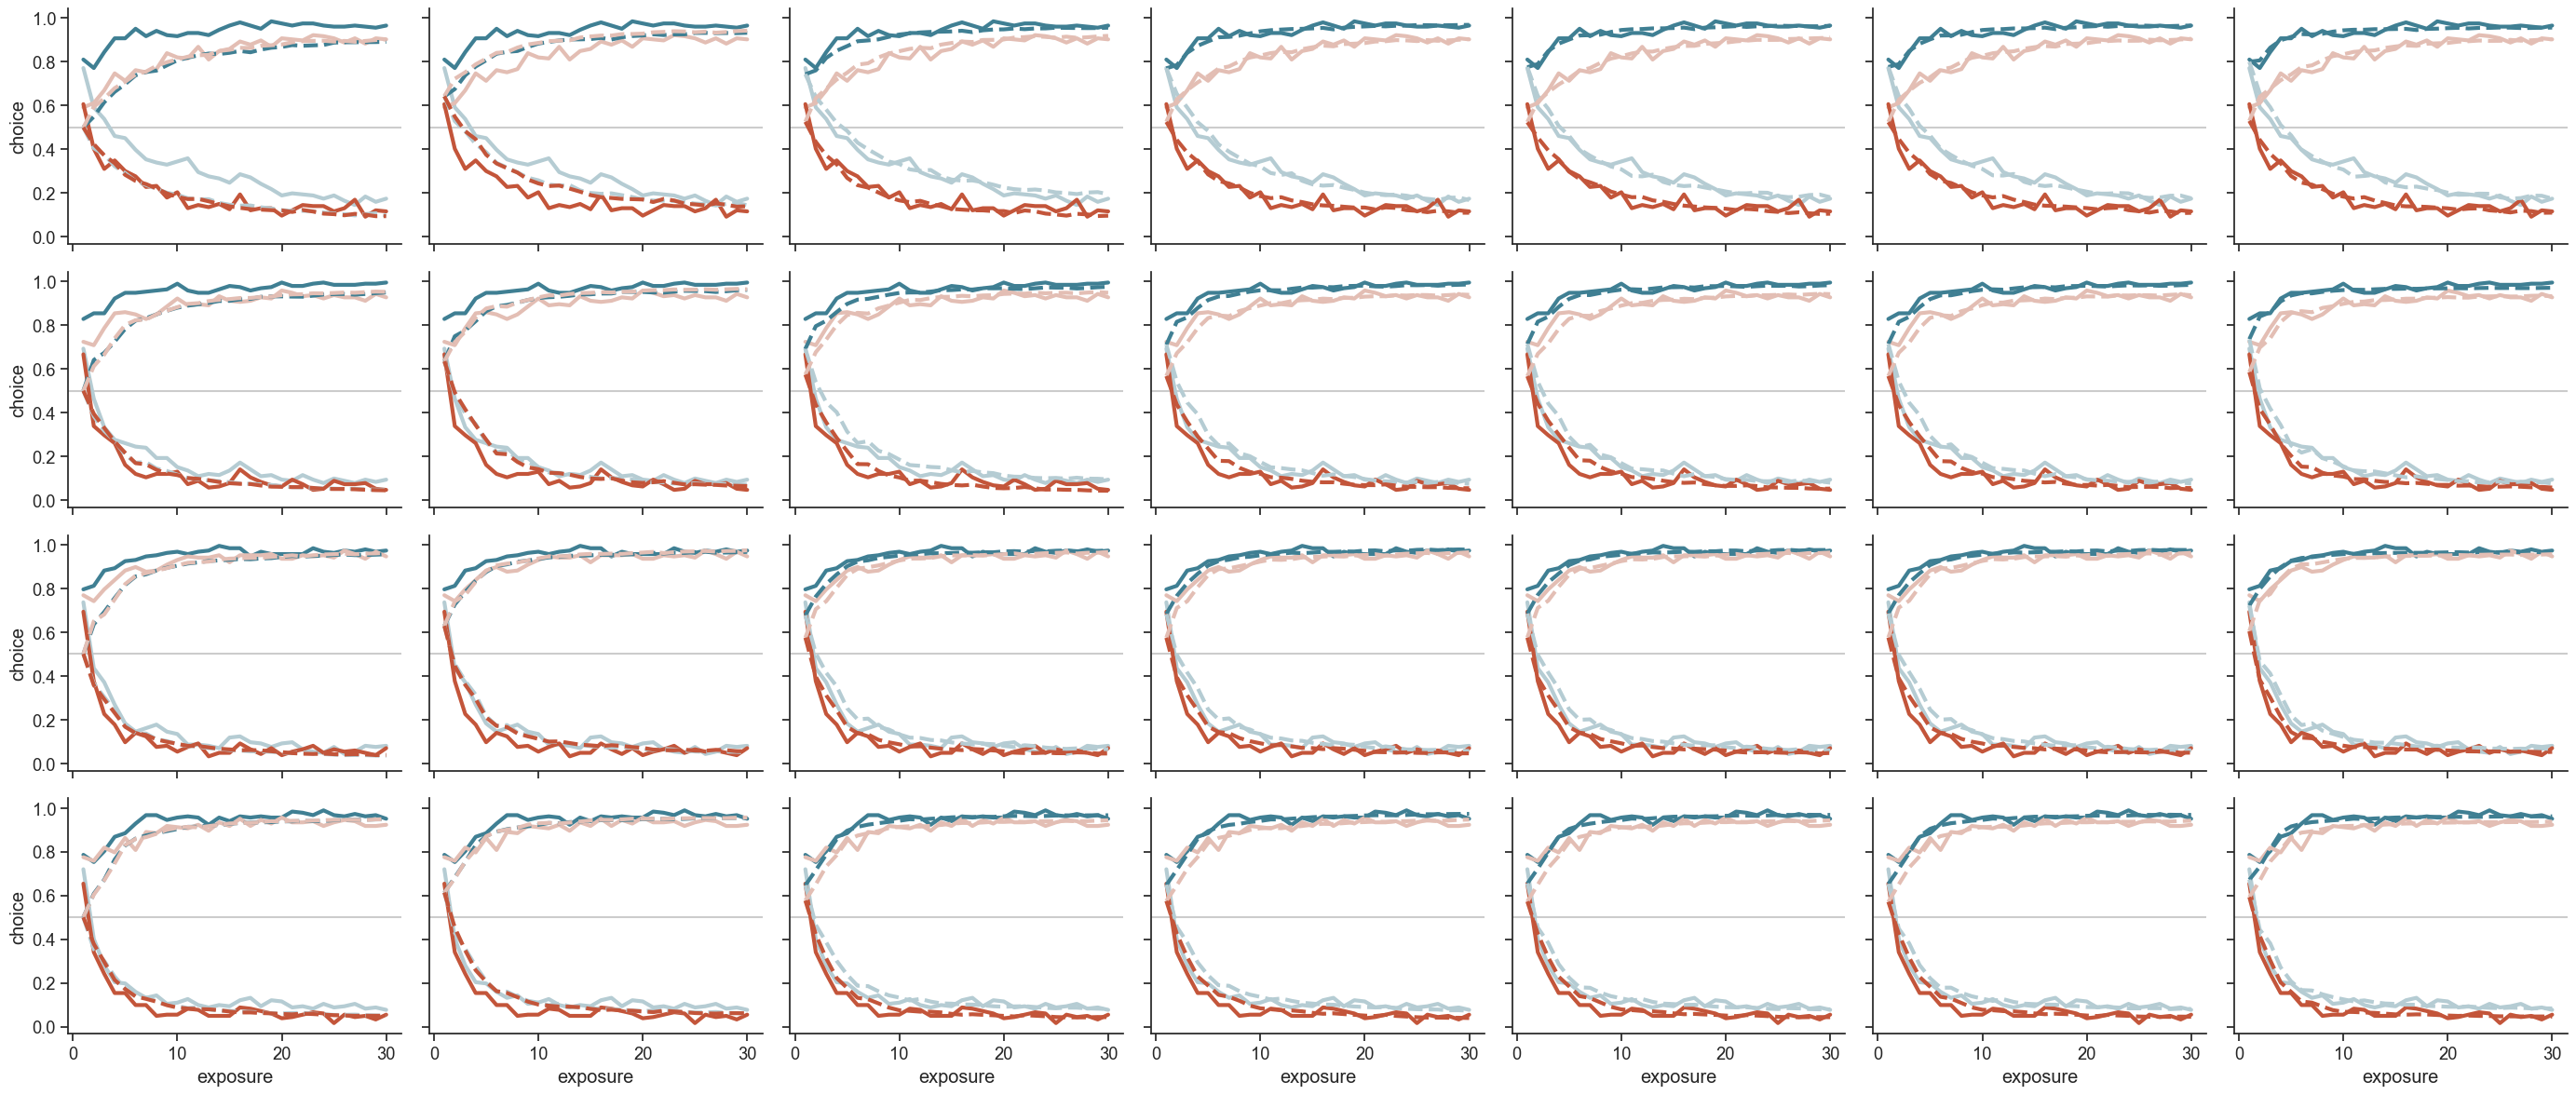

In [10]:
## Initialize canvas.
fig, axes = plt.subplots(len(sessions), len(models), figsize=(len(models)*4, len(sessions)*3),
                         sharex=True, sharey=True)

## Define aesthetics.
order = ['gw', 'ngw', 'gal', 'ngal']
palette = sns.diverging_palette(220, 20, n=4)

for i, s in enumerate(sessions):
    
    for j, m in enumerate(models):
        
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Plot learning curves.
        sns.lineplot(x='exposure', y='choice', hue='robot', data=ppc, hue_order=order,
                      palette=palette, lw=3, errorbar=None, ax=axes[i,j])
        sns.lineplot(x='exposure', y='Y_hat', hue='robot', data=ppc, hue_order=order, 
                      palette=palette, lw=3, errorbar=None, linestyle='--', ax=axes[i,j])

        ## Add trend line.
        axes[i,j].axhline(0.5, color='0.5', alpha=0.4, zorder=-10)
        
        ## Adjust legend.
        axes[i,j].legend_.set_visible(False)
        
sns.despine()
plt.tight_layout()

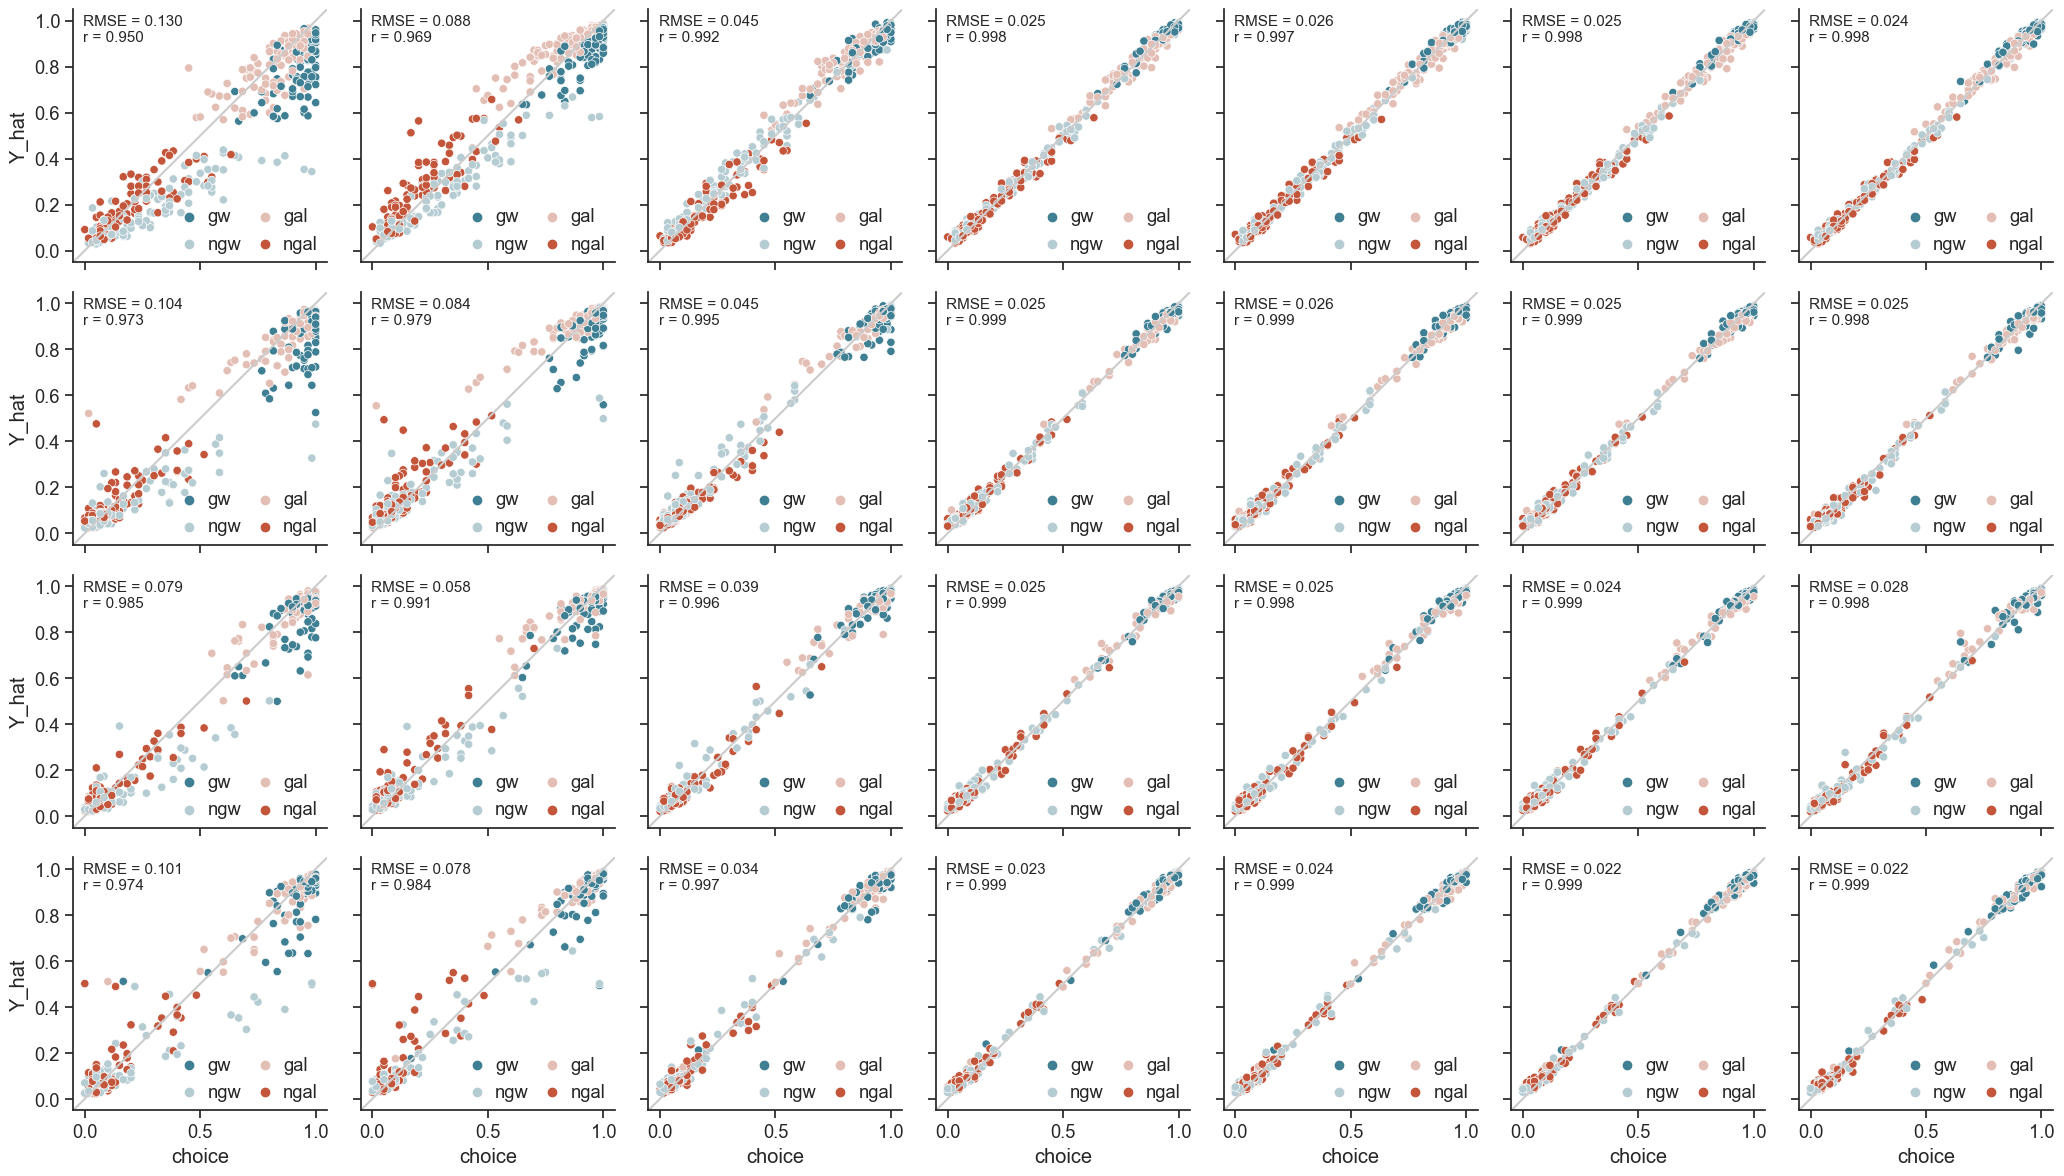

In [11]:
## Initialize canvas.
fig, axes = plt.subplots(len(sessions), len(models), figsize=(len(models)*3, len(sessions)*3),
                         sharex=True, sharey=True)

## Define aesthetics.
order = ['gw', 'ngw', 'gal', 'ngal']
palette = sns.diverging_palette(220, 20, n=4)

## Define convenience functions.
RMSE = lambda x: np.sqrt(np.mean(np.square(x)))

for i, s in enumerate(sessions):
    
    for j, m in enumerate(models):
        
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Compute accuracy by participant / condition.
        gb = ppc.groupby(['subject','robot']).agg({'choice':'mean', 'Y_hat':'mean'}).reset_index()
        
        ## Compute fit statistics.
        rmse = RMSE(gb.choice - gb.Y_hat)
        corr = gb[['choice','Y_hat']].corr().values[0,1]
        
        ## Plot learning curves.
        sns.scatterplot(x='choice', y='Y_hat', hue='robot', data=gb, hue_order=order, 
                        palette=palette, ax=axes[i,j])
        axes[i,j].plot([-1,2], [-1,2], color='0.8')
        
        ## Adjust x-axis.
        axes[i,j].set(xlim=(-0.05,1.05))
        
        ## Adjust y-axis
        axes[i,j].set(ylim=(-0.05,1.05))
        
        ## Adjust legend.
        axes[i,j].legend(loc=4, frameon=False, ncol=2, borderpad=0, handletextpad=0, columnspacing=0.3)
        
        ## Add annotation.
        annot = 'RMSE = %0.3f\nr = %0.3f' %(rmse, corr)
        axes[i,j].annotate(annot, (0,0), (0.04, 0.98), 'axes fraction', ha='left', va='top', fontsize=11)
        
sns.despine()
plt.tight_layout()

## Section 4: Parameter stability

In [12]:
## Define parameters.
pairs = list(combinations(['s1','s2','s3','s4'], 2))
params = ['b1','b2','b3','b4','a1','a2','c1']
model = 'pgng_m7'

## Main loop.
comparisons = []
for s1, s2 in pairs:
    
    ## Load samples.
    samples_1 = read_csv(os.path.join('stan_results', s1, f'{model}.tsv.gz'), 
                                      sep='\t', compression='gzip')
    samples_2 = read_csv(os.path.join('stan_results', s2, f'{model}.tsv.gz'), 
                         sep='\t', compression='gzip')
    
    ## Iterate over parameters.
    for p in params:
        
        ## Extract parameters.
        a = samples_1[f'{p}_mu'].values
        b = samples_2[f'{p}_mu'].values
        
        ## Summarize & report.
        mu1 = np.mean(a); mu2 = np.mean(b); delta = np.mean(a - b)
        lb, ub = hdi(a - b, hdi_prob=0.95)
        is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
        comparisons.append({'s1': s1, 's2': s2, 'param': p, 'Mean[1]': mu1, 'Mean[2]': mu2, 
                            'delta': delta, 'lb': lb, 'ub': ub, 'credible': is_credible})
        
## Convert to DataFrame.
comparisons = DataFrame(comparisons).set_index(['param','s1','s2']).sort_index()
comparisons.loc[params].round(3)

Mean[1]  Mean[2]   delta      lb      ub credible
param s1 s2                                                   
b1    s1 s2   12.073   32.635 -20.562 -28.556 -12.701       **
         s3   12.073   33.296 -21.223 -29.198 -13.547       **
         s4   12.073   32.031 -19.957 -28.701 -12.433       **
      s2 s3   32.635   33.296  -0.662 -11.912  10.006         
         s4   32.635   32.031   0.604 -10.070  12.830         
      s3 s4   33.296   32.031   1.266  -9.414  13.113         
b2    s1 s2   13.597   30.228 -16.631 -24.864  -8.014       **
         s3   13.597   31.262 -17.665 -25.888  -8.986       **
         s4   13.597   29.464 -15.867 -24.044  -7.598       **
      s2 s3   30.228   31.262  -1.034 -11.454  10.677         
         s4   30.228   29.464   0.764  -9.856  11.729         
      s3 s4   31.262   29.464   1.798  -9.220  12.234         
b3    s1 s2    1.844    1.356   0.488   0.096   0.899       **
         s3    1.844    1.170   0.674   0.308   1.055       **
         s4    1.844    0.946   0.898   0.507   1.298       **
      s2 s3    1.356    1.170   0.186  -0.196   0.564         
         s4    1.356    0.946   0.410  -0.003   0.809         
      s3 s4    1.170    0.946   0.224  -0.150   0.601         
b4    s1 s2    0.136    0.404  -0.268  -0.528  -0.040       **
         s3    0.136    0.502  -0.366  -0.606  -0.137       **
         s4    0.136    0.444  -0.308  -0.601  -0.027       **
      s2 s3    0.404    0.502  -0.098  -0.393   0.209         
         s4    0.404    0.444  -0.040  -0.398   0.278         
      s3 s4    0.502    0.444   0.058  -0.287   0.378         
a1    s1 s2    0.193    0.109   0.084   0.037   0.132       **
         s3    0.193    0.109   0.084   0.035   0.132       **
         s4    0.193    0.107   0.086   0.040   0.137       **
      s2 s3    0.109    0.109   0.000  -0.038   0.040         
         s4    0.109    0.107   0.002  -0.039   0.044         
      s3 s4    0.109    0.107   0.002  -0.040   0.040         
a2    s1 s2    0.114    0.088   0.025  -0.037   0.083         
         s3    0.114    0.107   0.007  -0.053   0.064         
         s4    0.114    0.096   0.017  -0.039   0.075         
      s2 s3    0.088    0.107  -0.018  -0.061   0.025         
         s4    0.088    0.096  -0.008  -0.047   0.031         
      s3 s4    0.107    0.096   0.010  -0.031   0.049         
c1    s1 s2    0.007    0.015  -0.008  -0.021   0.005         
         s3    0.007    0.008  -0.001  -0.013   0.011         
         s4    0.007    0.006   0.001  -0.010   0.013         
      s2 s3    0.015    0.008   0.007  -0.004   0.018         
         s4    0.015    0.006   0.009  -0.002   0.019         
      s3 s4    0.008    0.006   0.001  -0.008   0.011

## Section 5: Reliability

In [13]:
## Define paramaters.
model = 'pgng_m7'

## Load summary.
reliability = read_csv(os.path.join('stan_results', f'{model}_reliability.csv'))

### 5.1 Split-half reliability

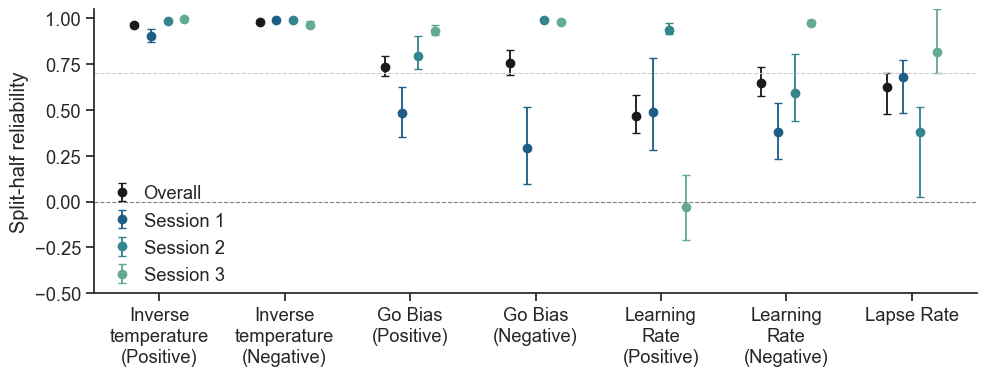

In [14]:
## Initialize canvas.
fig, ax = plt.subplots(1, 1, figsize=(10,4))
palette = np.append('k', sns.color_palette('crest_r', n_colors=3).as_hex())
labels = ['Overall','Session 1','Session 2', 'Session 3']
offsets = np.linspace(-0.2,0.2,4)

for i, (offset, color, label) in enumerate(zip(offsets, palette, labels)):

    ## Define points.
    y = reliability.query(f'Type == "sh" and Group == {i}').Mean
    x = np.arange(len(y)) + offset
    yerr = np.array([
        reliability.query(f'Type == "sh" and Group == {i}')['97.5%'] - y,
        y - reliability.query(f'Type == "sh" and Group == {i}')['2.5%']
    ])
    
    ## Plot.
    ax.errorbar(x, y, fmt='o', yerr=yerr, color=color, label=label, capsize=3, elinewidth=1.33)
    
## Add detail.
ax.axhline(0.7, color='0.8', lw=0.8, linestyle='--')
ax.axhline(0.0, color='0.5', lw=0.8, linestyle='--')
ax.legend(loc=3, frameon=False, borderpad=0, handletextpad=0.2)
ax.set(xticks=np.arange(7), ylim=(-0.5,1.05), ylabel='Split-half reliability')
ax.set_xticklabels(['Inverse\ntemperature\n(Positive)','Inverse\ntemperature\n(Negative)',
                    'Go Bias\n(Positive)','Go Bias\n(Negative)','Learning\nRate\n(Positive)',
                    'Learning\nRate\n(Negative)','Lapse Rate'])

sns.despine()
plt.tight_layout()

### 5.2 Test-retest reliability

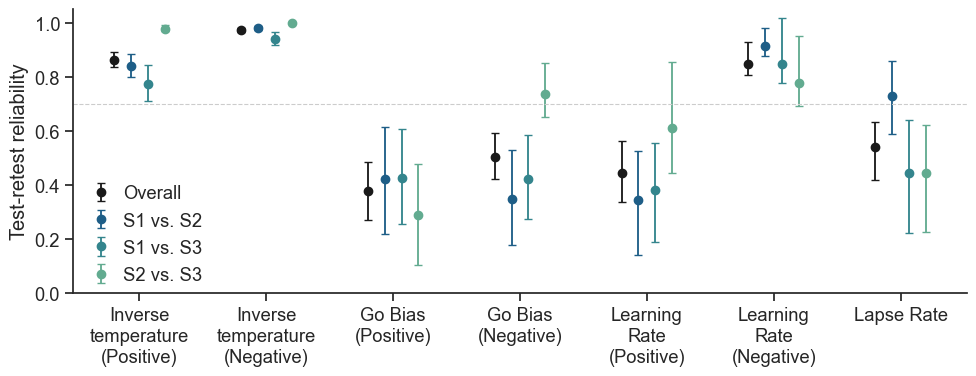

In [15]:
## Initialize canvas.
fig, ax = plt.subplots(1, 1, figsize=(10,4))
palette = np.append('k', sns.color_palette('crest_r', n_colors=3).as_hex())
labels = ['Overall','S1 vs. S2','S1 vs. S3', 'S2 vs. S3']
offsets = np.linspace(-0.2,0.2,len(labels))

for i, (offset, color, label) in enumerate(zip(offsets, palette, labels)):

    ## Define query.
    query = f'Type == "trt" and Group == {i}'
    
    ## Define points.
    y = reliability.query(query).Mean
    x = np.arange(len(y)) + offset
    yerr = np.array([
        reliability.query(query)['97.5%'] - y,
        y - reliability.query(query)['2.5%']
    ])
    
    ## Plot.
    ax.errorbar(x, y, fmt='o', yerr=yerr, color=color, label=label, capsize=3, elinewidth=1.33)
    
## Add detail.
ax.axhline(0.7, color='0.8', lw=0.8, linestyle='--')
ax.legend(loc=3, frameon=False, borderpad=0, handletextpad=0.2)
ax.set(xticks=np.arange(7), ylim=(0,1.05), ylabel='Test-retest reliability')
ax.set_xticklabels(['Inverse\ntemperature\n(Positive)','Inverse\ntemperature\n(Negative)',
                    'Go Bias\n(Positive)','Go Bias\n(Negative)','Learning\nRate\n(Positive)',
                    'Learning\nRate\n(Negative)','Lapse Rate'])

sns.despine()
plt.tight_layout()